### 사용 서버 및 사용량

In [22]:
import os
import tensorflow.compat.v1 as tf1

os.environ["CUDA_VISIBLE_DEVICES"] = "3"
config = tf1.ConfigProto()
config.gpu_options.per_process_gpu_memory_fraction = 0.05
session = tf1.Session(config=config)

2024-04-09 16:30:00.875229: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1639] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 2016 MB memory:  -> device: 0, name: NVIDIA A100-PCIE-40GB, pci bus id: 0000:af:00.0, compute capability: 8.0


### 이미지 불러오기

In [23]:
import os
import numpy as np

def read_images_from_path(path):
    image_files = [f for f in os.listdir(path) if f.endswith(".jpg")]
    images = [os.path.join(path, f) for f in image_files]
    return images

# 각 경로에서 이미지 파일을 가져와 변수에 저장
path_Mild_Demented = "./MRI_치매_데이터__/Mild_Demented_train/"
path_Non_Demented = "./MRI_치매_데이터__/Non_Demented_train/"

images_Mild_Demented = read_images_from_path(path_Mild_Demented)
images_Non_Demented = read_images_from_path(path_Non_Demented)

# 변수에 저장된 이미지 수 출력
print(f"Number of images in Mild_Demented: {len(images_Mild_Demented)}")
print(f"Number of images in Non_Demented: {len(images_Non_Demented)}")

Number of images in Mild_Demented: 627
Number of images in Non_Demented: 2240


In [24]:
print(np.shape(images_Mild_Demented[0]))

()


### 이미지 시각화

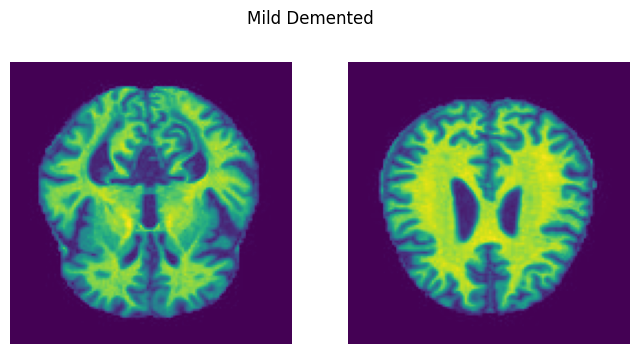

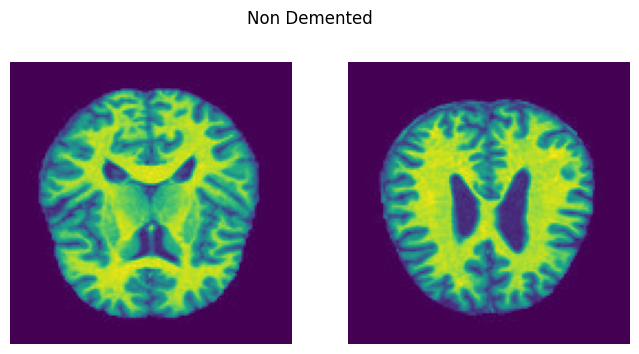

In [25]:
import os
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

def read_images_from_path(path, num_images=2):
    image_files = [f for f in os.listdir(path) if f.endswith(".jpg")][:num_images]
    images = [os.path.join(path, f) for f in image_files]
    return images

def plot_images(images, title):
    plt.figure(figsize=(8, 4))
    for i, image_path in enumerate(images, 1):
        plt.subplot(1, len(images), i)
        img = mpimg.imread(image_path)
        plt.imshow(img)
        plt.axis('off')
    plt.suptitle(title)
    plt.show()

# 각 경로에서 2장씩 이미지를 읽어와서 그림
images_Mild_Demented = read_images_from_path(path_Mild_Demented, num_images=2)
plot_images(images_Mild_Demented, title="Mild Demented")


images_Non_Demented = read_images_from_path(path_Non_Demented, num_images=2)
plot_images(images_Non_Demented, title="Non Demented")



### 이미지 넘파이 배열로 변환

In [26]:
import os
import matplotlib.image as mpimg
import numpy as np

def read_images_from_path(path):
    image_files = [f for f in os.listdir(path) if f.endswith(".jpg")]
    images = [os.path.join(path, f) for f in image_files]
    return images

def images_to_numpy(images):
    image_arrays = [mpimg.imread(image_path) for image_path in images]
    return np.array(image_arrays)

# 각 경로에서 모든 이미지를 읽어와서 numpy 배열로 변환
images_Mild_Demented = read_images_from_path(path_Mild_Demented) # 몇개, 가로, 세로
numpy_array_Mild_Demented = images_to_numpy(images_Mild_Demented)# 몇개, 가로, 세로


images_Non_Demented = read_images_from_path(path_Non_Demented)
numpy_array_Non_Demented = images_to_numpy(images_Non_Demented)


# 넘파이 배열의 크기 확인
print("Mild Demented Shape:", numpy_array_Mild_Demented.shape)
print("Non Demented Shape:", numpy_array_Non_Demented.shape)

Mild Demented Shape: (627, 128, 128)
Non Demented Shape: (2240, 128, 128)


In [ ]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from keras.callbacks import Callback
from keras.layers import Input, Dense, Lambda
from keras.models import Model
from sklearn import mixture
from sklearn.cluster import KMeans
import math
import scipy
import time

### 원하는 군집 이미지 선택

In [ ]:
# 정상 = numpy_array_Non_Demented
# 경증 = numpy_array_Mild_Demented

# 학습할 이미지
choose_cluster = numpy_array_Non_Demented

### 모델 학습 핵심 하이퍼파라미터 선택

In [ ]:
epochs = 1000
batch_size = 32

n_components = 10 # GMM에서 분포의 갯수 선택

### 이미지 생성 값 선택

In [ ]:
# 숫자
# 정상의 배수 = images_Non_Demented * ...
# 경증의 배수 = images_Mild_Demented * ...

make_image = (len(images_Non_Demented) * 2)

batch_size_images = 100 # 한번에 생성할 갯수 -> 100개씩 생성해라.


### GAE 데이터 학습

In [27]:
X_data = np.reshape(choose_cluster, (-1,128,128,1))

In [28]:
print(np.max(X_data), np.min(X_data))

255 0


In [29]:
X_data = X_data / 255.
print(np.max(X_data), np.min(X_data))

1.0 0.0


In [30]:
X_data = np.reshape(X_data, (-1,128*128))
print(np.shape(X_data))

(2240, 16384)


In [32]:
latent_dim = 256

# Encoder
encoder_inputs = keras.Input(shape=(128*128,))
x = layers.Dense(500, activation="relu")(encoder_inputs)
x = layers.Dense(500, activation="relu")(x)
x = layers.Dense(2000, activation="relu")(x)
z = layers.Dense(latent_dim)(x)

AE_encoder = keras.Model(encoder_inputs, z, name="encoder")

# Decoder
latent_inputs = keras.Input(shape=(latent_dim,))
x = layers.Dense(2000, activation="relu")(latent_inputs)
x = layers.Dense(500, activation="relu")(x)
x = layers.Dense(500, activation="relu")(x)
decoder_outputs = layers.Dense(128*128, activation="sigmoid")(x)
AE_decoder = keras.Model(latent_inputs, decoder_outputs, name='decoder')

In [33]:
# Compile the autoencoder
autoencoder_inputs = keras.Input(shape=(128*128,))
z = AE_encoder(autoencoder_inputs)
autoencoder_outputs = AE_decoder(z)
autoencoder = keras.Model(autoencoder_inputs, autoencoder_outputs, name='autoencoder')
autoencoder.compile(optimizer='adam', loss='binary_crossentropy')

st = time.time()
autoencoder.fit(X_data, X_data, batch_size=batch_size, epochs=epochs, verbose=0)
et = time.time() - st
print("총 걸린 시간 : ", et)
    
save_dir = './MRI_치매_데이터__/Save AE model'
if not os.path.exists(save_dir):
    os.makedirs(save_dir)

AE_encoder.save_weights(save_dir + "/encoder_GAE_Non_e1000.h5")
AE_decoder.save_weights(save_dir + "/decoder_GAE_Non_e1000.h5")

KeyboardInterrupt: 

In [ ]:
# Assuming you have already trained the autoencoder

# Encode input images to latent vectors
z_data = AE_encoder.predict(X_data) # 입력 이미지를 저차원의 잠재 공간으로 매핑

# Print the shape of the latent vectors
print(z_data.shape)

In [ ]:
# Get the z_mean and generate reconstructions
z = AE_encoder(X_data[:10]) 
# 처음 10개 입력 이미지 잠재공간으로 인코딩해서 잠재 벡터 z를 생성

reconstruction = AE_decoder(z)
# 잠재 벡터 z를 사용해 재구성 이미지 생성

# Reshape the images to match the plot layout
original_images = X_data[:10].reshape(10, 128, 128)
reconstructed_images = reconstruction.numpy().reshape(10, 128, 128)
# 이미지를 시각화 하기 위해 원본 이미지와 재구성 이미지를 각각 재구성

# Create a plot with 2 rows and 10 columns
fig, axs = plt.subplots(2, 10, figsize=(15, 3))
# 2행 10열의 subplot을 생성, 첫 번째 행은 원본, 두번쨰 행은 재구성(생성)한 이미지

# Plot the original images in the first row
for i in range(10):
    axs[0, i].imshow(original_images[i], cmap='gray')
    axs[0, i].axis('off')


# Plot the reconstructed images in the second row
for i in range(10):
    axs[1, i].imshow(reconstructed_images[i], cmap='gray')
    axs[1, i].axis('off')

    
# 원본 이미지와 재구성(생성)한 이미지를 반복문으로 subplot에 그림        
    
plt.tight_layout()
plt.show()

In [14]:
# reconstructed_images 배열에 저장된 재구성된 이미지를 사용
for i in range(n):
    for j in range(n):
        # 임의로 시작 인덱스를 조절할 수 있습니다. 여기서는 50으로 시작
        digit_idx = (i * n + j) + 50
        if digit_idx < len(reconstructed_images):  # digit_idx가 배열 범위 내인지 확인
            digit = reconstructed_images[digit_idx]
            figure[i * digit_size : (i + 1) * digit_size,
                   j * digit_size : (j + 1) * digit_size] = digit

# 시각화 설정
plt.figure(figsize=(10, 10))
plt.imshow(figure, cmap="Greys_r")
plt.axis('off')  # 축 정보 제거
plt.show()

In [15]:
print(reconstruction[0])

tf.Tensor(
[1.0866868e-06 1.1849123e-06 1.2469253e-06 ... 1.2686830e-06 1.1630993e-06
 1.3608372e-06], shape=(16384,), dtype=float32)


In [16]:
# 기본 값은 분포 10개 (n_components)
# 분포의 갯수를 바꾸려면 n_components의 값을 바꾸면 됌

import matplotlib.pyplot as plt
from sklearn.mixture import GaussianMixture

# GMM 모델 학습
gmm = GaussianMixture(n_components, random_state=42)
st = time.time()
gmm.fit(z_data)
# 저차원의 분포 P(z | X)를 10개의 가우시안분포로 혼합해서 분포를 추정함

et_2 = time.time() - st
print("분포추정 총 걸린 시간 : ", et_2)

# GMM 모델의 가중치 출력
print("Weights:")
print(gmm.weights_)

# GMM 모델의 평균 벡터 출력
print("\nMeans:")
print(gmm.means_)

# GMM 모델의 공분산 행렬 출력
print("\nCovariances:")
print(gmm.covariances_)

분포추정 총 걸린 시간 :  34.53876519203186
Weights:
[0.11800477 0.08632827 0.18009714 0.04140625 0.08515704 0.08281303
 0.10074444 0.13984303 0.07304488 0.09256115]

Means:
[[ 0.03547729 -0.02995263  0.03650638 ...  0.46481259 -0.00656096
  -0.0039638 ]
 [-0.02892875 -0.10829323  0.00815396 ...  0.4140002   0.01747652
   0.1260832 ]
 [ 0.10140933 -0.03941663  0.03878992 ...  1.18347534  0.00327547
   0.00286077]
 ...
 [ 0.01326479  0.0023287   0.01662318 ...  0.37114745  0.02814621
   0.04998301]
 [ 0.13889878 -0.18713838  0.03369359 ...  1.50896869  0.02829691
  -0.10264953]
 [ 0.06955464 -0.21688687 -0.05373953 ...  0.58776081 -0.01174988
   0.00977681]]

Covariances:
[[[ 8.52034463e-02  6.51532689e-03 -2.80685944e-03 ... -3.12823050e-03
   -2.51956204e-03 -6.42321345e-03]
  [ 6.51532689e-03  2.56230632e-02 -5.41834055e-03 ... -2.31394750e-03
   -6.99057783e-04 -2.51021413e-03]
  [-2.80685944e-03 -5.41834055e-03  2.46818782e-02 ...  1.65918182e-02
    2.29867831e-04  4.74706062e-03]
  ...
  [

In [17]:
n_samples_per_cluster = 10
samples = []

for i in range(gmm.n_components):
    mean = gmm.means_[i]  
    covariance = gmm.covariances_[i]  

    samples_per_cluster = np.random.multivariate_normal(mean, covariance, n_samples_per_cluster)
    samples.extend(samples_per_cluster)
print(np.shape(samples))

(100, 256)


4/4 [==============================] - 0s 4ms/step


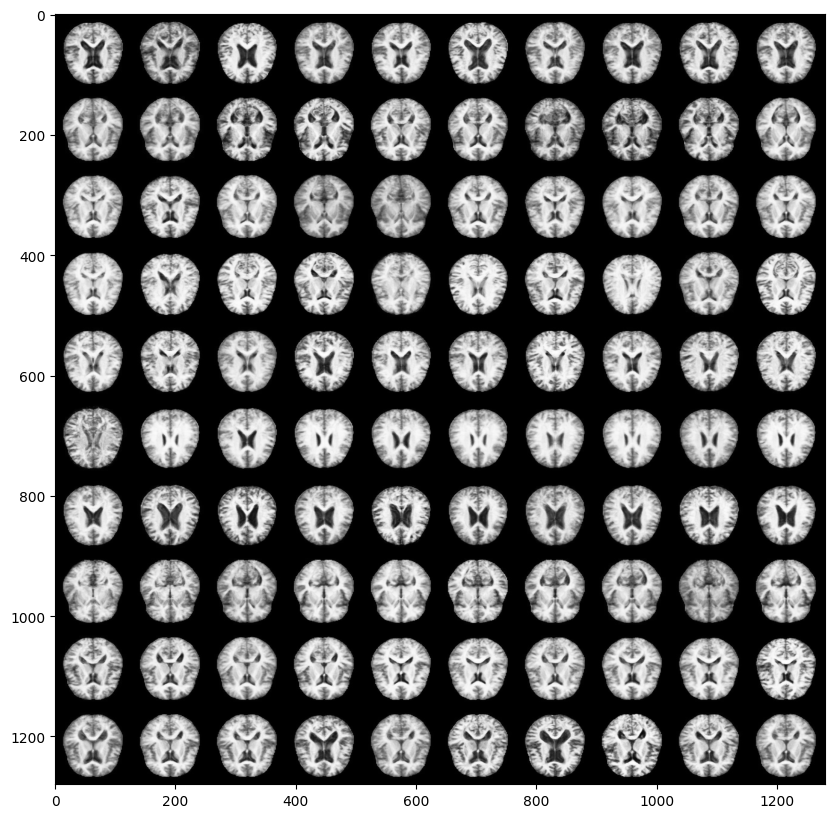

In [18]:
x_generated = AE_decoder.predict(np.array(samples))

n = 10
digit_size = 128
figure = np.zeros((digit_size * n, digit_size * n))

for i in range(n):
    for j in range(n):
        digit_idx = i * n + j
        digit = np.reshape(x_generated[digit_idx], (128, 128))
        figure[
            i * digit_size : (i + 1) * digit_size,
            j * digit_size : (j + 1) * digit_size,
        ] = digit

plt.figure(figsize=(10, 10))
plt.imshow(figure, cmap="Greys_r")
plt.show()

### GAE 데이터 생성 저장

In [3]:
import os
import numpy as np
from tensorflow.keras.preprocessing.image import array_to_img

# 이미지를 저장할 디렉토리 경로 설정
save_dir = "./MRI_치매_데이터__생성_new/GAE_Non_e1000_n10_real-data-vector_1"
if not os.path.exists(save_dir):
    os.makedirs(save_dir)

# 이미지 생성 및 저장을 위한 배치 처리
batch_size_images = batch_size_images  # 한 번에 처리할 이미지 수
make_image = make_image  # 총 생성할 이미지 수

for i in range(0, n_images, batch_size):
    n_samples = min(batch_size, n_images - i)
    samples = gmm.sample(n_samples)[0]  # 여러 샘플을 한 번에 생성

    # VAE 디코더를 사용하여 이미지 생성
    generated_images = AE_decoder.predict(samples)

    for j, generated_image in enumerate(generated_images):
        # 생성된 이미지를 128x128 크기로 변환
        generated_image = generated_image.reshape((128, 128, 1))

        # 이미지 배열을 이미지로 변환
        img = array_to_img(generated_image * 255.0, scale=False)  # [0, 255] 스케일로 변환

        # 이미지 파일 저장
        img.save(os.path.join(save_dir, f"generated_image_{i+j+1}.jpg"))

    # 진행 상태 메시지 출력
    print(f"{i+n_samples}개의 이미지 생성 및 저장 완료.")

print(f"총 {n_images}개의 이미지 생성 및 저장 완료.")
